In [1]:
#from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
import json
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [2]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [3]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [4]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

In [46]:
def stretch_simulated_feats(data, stretch,true_feats = ['Vx','Vy','Vz'],
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    for feature in true_feats:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

In [47]:
def amp_sim_feats(data, amp_stretch,true_feats = ['Vx','Vy','Vz'],
                           suffix="_stretch_amp"):
    '''
    vary amplitude for simulation to better match true data,
    for a single sattelite;
    use predetermined amp_stretch coefficient (depends on the satellite)
    
    '''
    for feature in true_feats:
        data[feature+suffix] = amp_stretch*data[feature+'_stretch']
    
    return data

In [6]:
#!jupyter nbconvert --to script utils_edit_mb.ipynb

In [7]:
s_data = pd.read_csv('./data/train.csv', index_col= 'id')

In [8]:
#s_data_test = pd.read_csv('./data/test.csv', index_col= 'id')

In [9]:
data = get_satellite_data(s_data, 0)
data.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,13419.744899,19007.658296,30280.477329,-0.849621,2.201501,-2.039018
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,10662.661170,24548.177490,23720.743216,-1.116261,1.715430,-2.636835
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,7182.757625,28395.590633,15553.985280,-1.360095,0.984696,-3.173250
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,3099.591832,29798.085757,6083.094021,-1.536935,-0.033515,-3.544768


In [10]:
data_rtjf = remove_time_jumps_fast(data)
data_rtjf.tail()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t,dt
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,17269.627379,-2275.948161,39925.025372,-0.084964,2.656988,-0.290960,30.852471,0.032442
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,16696.850918,5166.718053,38337.176299,-0.326478,2.635548,-0.847468,30.884913,0.032442
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946,30.917355,0.032442
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,13419.744899,19007.658296,30280.477329,-0.849621,2.201501,-2.039018,30.949797,0.032442
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,10662.661170,24548.177490,23720.743216,-1.116261,1.715430,-2.636835,30.982239,0.032442


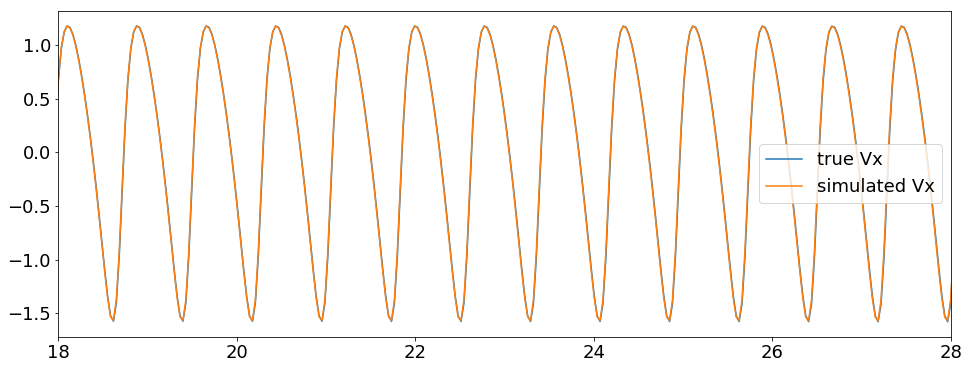

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx');
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx');

plt.xlim([18,28]);
plt.legend();

In [12]:
#run for all satellites and print sat id if error occurs
from tqdm import tqdm
for i in tqdm(range(600)):
    try:
        remove_time_jumps_fast(get_satellite_data(s_data, i))
    except:
        print(i)

100%|██████████| 600/600 [00:07<00:00, 83.42it/s] 


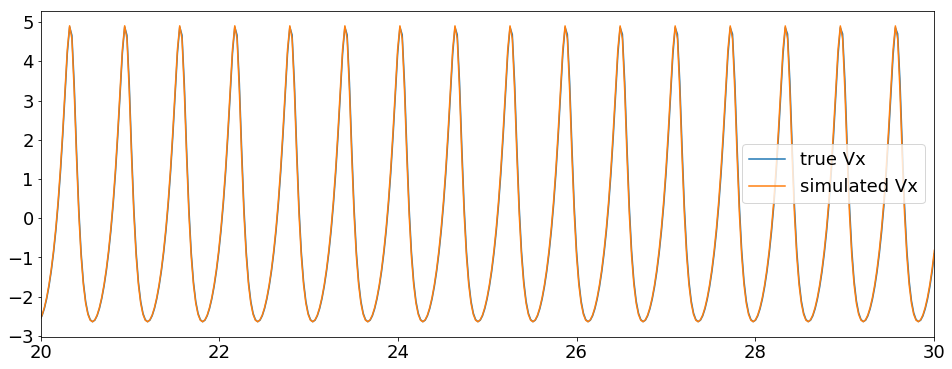

In [13]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 4))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx');
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx');

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

## Explore time scale stretch for simulations

In [36]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

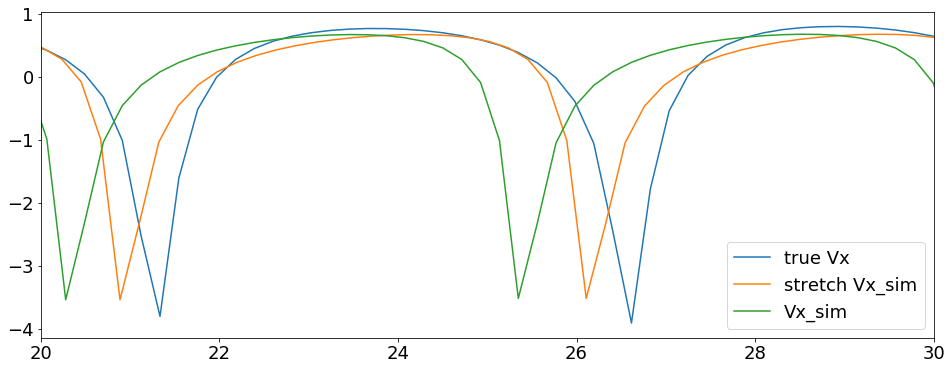

In [15]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 391))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vz'], label = 'true Vx');
plt.plot(1.03*data['t'],data['Vz_sim'], label = 'stretch Vx_sim');
plt.plot(data['t'],data['Vz_sim'], label = 'Vx_sim');

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

In [16]:
smape(data[true_feats].to_numpy(),data[sim_feats].to_numpy())

0.35520692028371315

In [17]:
data = stretch_simulated_feats(data,1.05)
smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())

0.2304495975754143

In [18]:
data.columns

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim', 't', 'dt', 'x_stretch',
       'y_stretch', 'z_stretch', 'Vx_stretch', 'Vy_stretch', 'Vz_stretch'],
      dtype='object')

In [37]:
stretch_dict = {}
for sat in tqdm(s_data['sat_id'].unique()):
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.97,1.03,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

100%|██████████| 600/600 [00:43<00:00, 13.83it/s]


In [38]:
extreme_stretch = {k for k,v in stretch_dict.items() if (v <= 0.97 or v >= 1.03)}

In [39]:
for sat in extreme_stretch:
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.92,1.08,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

In [40]:
for sat in extreme_stretch:
    print(sat,stretch_dict[sat])

515 1.0550000000000002
252 0.9500000000000001
556 0.9700000000000001
391 1.04


In [41]:
stretch_dict = {int(k):v for k,v in stretch_dict.items()}

#save stretch_dict
import json
with open('stretch_dict.txt', 'w') as file:
    json.dump(stretch_dict, file)

#with open('stretch_dict.txt', 'r') as file:
#    stretch_dict = json.load(file)


## Amplitude stretch

In [42]:
# satellite 391 needs amplitude stretched
with open('stretch_dict.txt', 'r') as file:
    stretch_dict = json.load(file) #keys as strings
stretch_dict = {int(k) : v for k,v in stretch_dict.items()}
stretch_dict[391]

1.04

In [43]:
data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t,dt,Vx_stretch,Vy_stretch,Vz_stretch
0,2014-01-01T00:00:00.000,391,-10381.224584,-31461.169121,6281.991221,-2.450438,0.049883,-3.799618,-5461.180830,-31871.563069,14057.913996,-2.588056,-0.554435,-3.522290,0.000000,NaN,-2.588056,-0.554435,-3.522290
1,2014-01-01T05:04:10.728,391,-31717.600229,1974.956487,-50075.598496,-0.195897,2.462518,-2.036259,-31845.310774,-4639.864247,-44923.901587,-0.368911,2.439566,-2.267348,0.211235,0.211235,-0.467271,2.377776,-2.372681
2,2014-01-01T10:08:21.455,391,-28886.214522,44221.621977,-75453.528348,0.374379,2.120987,-0.914626,-30613.570622,38140.680483,-73118.924577,0.336042,2.172982,-1.014945,0.422471,0.211235,0.282435,2.265399,-1.160792
3,2014-01-01T15:12:32.183,391,-20338.029115,79412.158280,-86983.234913,0.532921,1.748041,-0.403019,-22364.394558,74147.307676,-85971.060323,0.529135,1.790423,-0.454365,0.633706,0.211235,0.503839,1.856536,-0.539100
4,2014-01-01T20:16:42.910,391,-10059.761082,108478.007319,-91443.069648,0.583386,1.447818,-0.108656,-11989.410700,103815.434623,-91159.070116,0.592427,1.476832,-0.138077,0.844941,0.211235,0.580429,1.567874,-0.220284


In [44]:
stretch_amp_sim_feats(data,2).head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,...,Vy_sim,Vz_sim,t,dt,Vx_stretch,Vy_stretch,Vz_stretch,Vx_stretch_amp,Vy_stretch_amp,Vz_stretch_amp
0,2014-01-01T00:00:00.000,391,-10381.224584,-31461.169121,6281.991221,-2.450438,0.049883,-3.799618,-5461.180830,-31871.563069,...,-0.554435,-3.522290,0.000000,NaN,-2.588056,-0.554435,-3.522290,-5.176111,-1.108871,-7.044579
1,2014-01-01T05:04:10.728,391,-31717.600229,1974.956487,-50075.598496,-0.195897,2.462518,-2.036259,-31845.310774,-4639.864247,...,2.439566,-2.267348,0.211235,0.211235,-0.467271,2.377776,-2.372681,-0.934541,4.755553,-4.745362
2,2014-01-01T10:08:21.455,391,-28886.214522,44221.621977,-75453.528348,0.374379,2.120987,-0.914626,-30613.570622,38140.680483,...,2.172982,-1.014945,0.422471,0.211235,0.282435,2.265399,-1.160792,0.564870,4.530798,-2.321585
3,2014-01-01T15:12:32.183,391,-20338.029115,79412.158280,-86983.234913,0.532921,1.748041,-0.403019,-22364.394558,74147.307676,...,1.790423,-0.454365,0.633706,0.211235,0.503839,1.856536,-0.539100,1.007677,3.713073,-1.078201
4,2014-01-01T20:16:42.910,391,-10059.761082,108478.007319,-91443.069648,0.583386,1.447818,-0.108656,-11989.410700,103815.434623,...,1.476832,-0.138077,0.844941,0.211235,0.580429,1.567874,-0.220284,1.160858,3.135749,-0.440568


In [48]:
amp_dict = {}
for sat in tqdm(s_data['sat_id'].unique()):
    amplitude_list = []
    for i in np.arange(0.9,1.1,0.005):
        data = stretch_simulated_feats(data,stretch_dict[sat])
        data = amp_sim_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretch_amp_feats].to_numpy())
        amplitude_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(amplitude_list, key = lambda t: t[1])
    amp_dict[sat] = best[0]

100%|██████████| 600/600 [02:29<00:00,  4.02it/s]


In [49]:
extreme_amp = {k for k,v in amp_dict.items() if (v <= 0.9 or v >= 1.1)}

In [50]:
extreme_amp

set()

In [51]:
amp_dict = {int(k):v for k,v in amp_dict.items()}
#save stretch_dict
import json
with open('amp_dict.txt', 'w') as file:
    json.dump(amp_dict, file)

#with open('amp_dict.txt', 'r') as file:
#    amp_dict = json.load(file)


In [52]:
amp_dict

{0: 1.04,
 1: 1.04,
 2: 1.04,
 3: 1.04,
 4: 1.04,
 5: 1.04,
 6: 1.0300000000000002,
 7: 1.04,
 8: 1.04,
 9: 1.04,
 10: 1.04,
 11: 1.0250000000000001,
 12: 1.04,
 13: 1.04,
 14: 1.04,
 15: 1.04,
 16: 1.04,
 17: 1.04,
 18: 1.04,
 19: 1.04,
 20: 0.9950000000000001,
 21: 1.04,
 22: 1.0050000000000001,
 23: 1.04,
 24: 1.04,
 25: 1.04,
 26: 1.04,
 27: 1.04,
 28: 1.0350000000000001,
 29: 1.04,
 30: 1.04,
 31: 1.0300000000000002,
 32: 1.04,
 33: 1.04,
 34: 1.04,
 35: 0.9950000000000001,
 36: 1.04,
 37: 1.0050000000000001,
 38: 1.04,
 39: 1.04,
 40: 1.04,
 41: 1.04,
 42: 1.04,
 43: 1.04,
 44: 1.04,
 45: 1.04,
 46: 1.04,
 47: 1.04,
 48: 1.04,
 49: 1.04,
 50: 1.04,
 51: 1.04,
 52: 1.0300000000000002,
 53: 1.04,
 54: 1.04,
 55: 1.04,
 56: 1.0300000000000002,
 57: 1.04,
 58: 1.04,
 59: 1.04,
 60: 1.04,
 61: 1.04,
 62: 1.04,
 63: 1.04,
 64: 1.04,
 65: 1.04,
 66: 1.04,
 67: 1.04,
 68: 1.04,
 69: 1.04,
 70: 1.04,
 71: 1.0250000000000001,
 72: 1.04,
 73: 1.04,
 74: 1.04,
 75: 1.04,
 76: 1.04,
 77: 1.04

In [49]:
def best_stretch_coefficient(data, threshold = 0.05, iterations = 100,
                            true_feats = ['x','y','z','Vx','Vy','Vz']):
    '''
    find stretch coefficient that yields best smape for given satellite
    iterations: max number of iterations
    
    '''
    